In [26]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
import pandas as pd

chromedriver_path = '/Users/abjodas/Downloads/chromedriver-mac-arm64/chromedriver'
chrome_options = Options()
service = Service(chromedriver_path)

driver = webdriver.Chrome(service = service, options = chrome_options)

driver.get('https://www.linkedin.com/login')
email_field = driver.find_element(By.ID, 'username')
email_field.send_keys('exampleemail@example.com')

password_field = driver.find_element(By.ID, 'password')
password_field.send_keys('password')
password_field.submit()

time.sleep(5)

driver.get('https://www.linkedin.com/jobs/')

time.sleep(5)

search_field = driver.find_element(By.CSS_SELECTOR, 'input.jobs-search-box__text-input')
search_field.send_keys('Data Scientist')

location_field = driver.find_element(By.CSS_SELECTOR, 'input.jobs-search-box__text-input[aria-label="City, state, or zip code"]')
location_field.clear()  # Clear the current location
location_field.send_keys('San Francisco, CA')

search_field.send_keys(Keys.RETURN)

time.sleep(5)

# Find the job results container
job_results_container = driver.find_element(By.CLASS_NAME, 'jobs-search-results-list')

# Scroll gradually to load more job listings
scroll_pause_time = 2
last_height = driver.execute_script("return arguments[0].scrollHeight", job_results_container)

while True:
    # Scroll down a bit within the job results container
    driver.execute_script("arguments[0].scrollTop += 500", job_results_container)

    # Wait for new job listings to load
    time.sleep(scroll_pause_time)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return arguments[0].scrollHeight", job_results_container)
    if new_height == last_height:
        break
    last_height = new_height

soup = BeautifulSoup(driver.page_source, 'html.parser')

job_listings = soup.find_all('div', class_ = 'job-card-container')
job_details_list = []

# Check if job listings are found
if not job_listings:
    print("No job listings found.")
else:
    for job in job_listings:
        # Extract the job title
        title_tag = job.find('span', {'aria-hidden': 'true'}).find('strong')
        title = title_tag.get_text(strip=True) if title_tag else 'No title found'
        
        # Extract the company description
        company_tag = job.find('span', class_='job-card-container__primary-description')
        company = company_tag.get_text(strip=True) if company_tag else 'No company found'
        
        # Extract the location
        location_tag = job.find('li', class_='job-card-container__metadata-item')
        location = location_tag.get_text(strip=True) if location_tag else 'No location found'
        
        # Click the job listing to load the job details
        job_link = job.find('a')['href']
        driver.get(f"https://www.linkedin.com{job_link}")
        time.sleep(3)  # Wait for job details to load

        # Click the "See more" button if it exists
        try:
            see_more_button = driver.find_element(By.CSS_SELECTOR, 'button.jobs-description__footer-button')
            see_more_button.click()
            time.sleep(2)  # Wait for the full description to load
        except:
            pass  # If the button doesn't exist, continue
        
        # Get the page source and parse it with Beautiful Soup
        job_soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Extract the job details
        job_details_wrapper = job_soup.find('div', class_='jobs-description-content__text')
        job_details = job_details_wrapper.get_text(strip=True) if job_details_wrapper else 'No details found'
        
        # Store the job details
        job_details_list.append({
            'Title': title,
            'Company': company,
            'Location': location,
            'Details': job_details
        })


driver.quit()

# Convert the list of job details to a DataFrame
df = pd.DataFrame(job_details_list)

# Save the DataFrame to a CSV file
df.to_csv('linkedin_job_details.csv', index=False)

# Print the DataFrame
print(df)

                                                Title                 Company  \
0                          AI & Data Scientist Intern        Refonte Learning   
1             AI & Data Science Training & Internship    Refonte Technologies   
2                        AI & Data Science Internship        Refonte Learning   
3                        Paid Intern- Python Bootcamp          Nebula Academy   
4                        AI & Data Engineering Intern    Refonte Technologies   
5                                 Data Science Intern        Oeson | Learning   
6                                      Data Scientist                 kipi.bi   
7   Entry Level - Research Data Analyst (Remote) I...   Herr Alexander Wunsch   
8                    Data Analytics Training & Intern    Refonte Technologies   
9   Entry Level - Research Data Analyst (Remote) I...   Herr Alexander Wunsch   
10                               Intern, Data Science                 Kapitus   
11                          

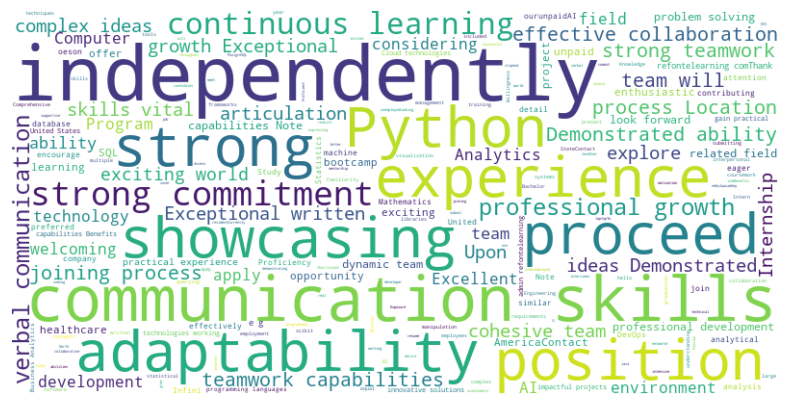

In [88]:


import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

# Load the job details from the CSV file
df = pd.read_csv('linkedin_job_details.csv')

# Function to extract qualifications from job details
def extract_qualifications(text):
    # Use a regular expression to find the first instance of "Qualifications" and capture the text that follows
    match = re.search(r'Qualifications:(.*?)(?:\n[A-Z][a-z]+:|$)', text, re.DOTALL)
    if match:
        qualifications_section = match.group(1).strip()
        return qualifications_section
    return ""

# Apply the function to extract qualifications
df['Qualifications'] = df['Details'].apply(extract_qualifications)

# Combine all qualifications into a single string
qualifications_text = " ".join(df['Qualifications'].dropna())

# Check if any qualifications were extracted
if not qualifications_text.strip():
    raise ValueError("No qualifications found in the job descriptions.")

additional_stopwords = {'data', 'private', 'degree','limited', 'highlighting', 'Refonte','science', 'application', 'details', 'contact', 'work', 'Currently', 'pursuing', 'part', 'learn', 'us', 'please', 'remote'}

stopwords = STOPWORDS.union(additional_stopwords)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    contour_color='steelblue',
    contour_width=3,
    colormap='viridis',
    stopwords = stopwords
).generate(qualifications_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Save the word cloud as an image file
wordcloud.to_file('qualifications_wordcloud.png')

In [66]:
df.iloc[4,4]

'- Currently pursuing a degree in Computer Science, Engineering, or related fields, demonstrating a strong commitment to continuous learning and professional growth.- Proficient in programming languages such as Python, Java, or SQL.- Familiarity with database management systems (e.g., MySQL, PostgreSQL).- Strong analytical and problem-solving skills, with attention to detail.- Excellent written and verbal communication skills, essential for effective collaboration and conveying complex concepts.- Ability to work independently and as part of a team, showcasing adaptability and strong teamwork capabilities.Note:This position is unpaid. After submitting your application, our team will contact you to proceed with the application details and joining process.Location:Remote, United States of AmericaContact:To embark on an exciting journey in AI & Data Engineering with us, please contact us at contact@refontelearning.com.'